### IMPORTS

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.rcParams["figure.figsize"]=8,8
import math
import numpy as np
import pandas as pd
from scipy import stats
import scipy
import scipy.stats as stat
from scipy.interpolate import make_interp_spline, BSpline
from lmfit.models import Model

### DATA COLLECTION

In [4]:
#NOTES
#High Voltage from Scintillator 1113.0 ± 1 Volts
#Measured the Impedance 50ohms ± 0.1
#4A -> 1.940microsec 1.940microsec

In [5]:
files = ['Sifted Data.data', 'Sifted_data2.data']
data = np.loadtxt(files[0], dtype = int)
data2 = np.loadtxt(files[1], dtype = int)
data = np.delete(data, 1, 1)
data2 = np.delete(data2, 1, 1)[3000:]
print(f'{len(data)} events recorded for {files[0]}')
print(f'{len(data2)} events recorded for {files[1]}')

3000 events recorded for Sifted Data.data
3240 events recorded for Sifted_data2.data


In [6]:
threshdata = pd.read_csv('FPGA_data.txt', sep=" ")
threshdata

,OSC,FPGA
0,0.628,0.648
1,2.000,2.000
2,2.000,2.000
3,2.000,2.000
4,2.000,2.000
...,...,...
96,20.000,19.980
97,20.000,19.980
98,20.000,19.980
99,20.000,19.980


In [7]:
## convert your array into a dataframe
df = pd.DataFrame(data/1000)
df2 = pd.DataFrame(data2/1000)
# print(df, df2)
# print(df.loc[(df!=0).any(axis=1)])
print(f'{len(df)} events zero fixed for {files[0]}')
print(f'{len(df2)} events zero fixed for {files[1]}')
## save to xlsx file
# df.to_excel('sifted.xlsx', index=False)

3000 events zero fixed for Sifted Data.data
3240 events zero fixed for Sifted_data2.data


### MUON LIFETIME EXPERIMENT

Equation: [273.61482692   2.03866767   0.87173654] 

A    =  273.61482692109035 +/- 7.7909672690434615
tau  =  2.0386676671252744 +/- 0.04808134061958609
B    =  0.871736537232112 +/- 0.21722352147793308

chi_sqrd 70.03960576517363 rd_chi 0.8438506718695619
p-test value :  0.8440294265385883 dof: 83 

Tau: 2.0386676671252744 Lit Tau: 2.1969811 ± 0.0000022μs
 7.2059533363635015%
Covariance1 Array: [6.06991710e+01 2.31181532e-03 4.71860583e-02]
Stdevv A 7.7909672690434615
Stdevv tau 0.04808134061958609
Stdevv B 0.21722352147793308


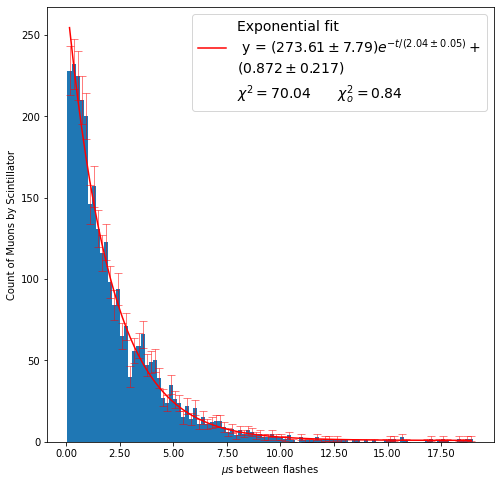

Equation: [298.65379128   2.04907916   0.75904104] 

A    =  298.65379127807824 +/- 8.099176529759342
tau  =  2.0490791628450733 +/- 0.045533229732543624
B    =  0.7590410419491777 +/- 0.22818457041662732

chi_sqrd 64.58159211056406 rd_chi 0.8072699013820508
p-test value :  0.8950414083286828 dof: 80 

Tau: 2.0490791628450733 Lit Tau: 2.1969811 ± 0.0000022μs
 6.732053232270711%
Covariance1 Array: [6.55966605e+01 2.07327501e-03 5.20681982e-02]
Stdevv A 8.099176529759342
Stdevv tau 0.045533229732543624
Stdevv B 0.22818457041662732


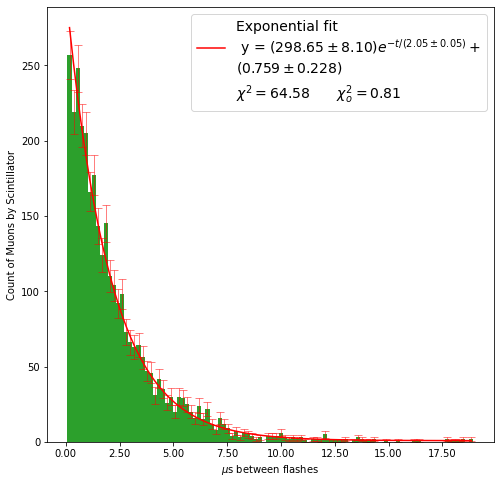

mean tau = 2.043873414985174 ± 0.0015526557346075087
relative error 6.969003284317108%


In [84]:
def muon_lifetime(df, data, c, out):
    fig1, ax1 = plt.subplots()
    # Plotting and calculations
    ax1.hist(df,bins=100, color=c)
    y,binEdges = np.histogram(data/1000,bins=100)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    yerror = np.sqrt(y) # np.full(86,5)
    yerror = yerror[yerror != 0]
    y_zerofixed = y[y != 0]
    bincenters = bincenters[y != 0]
    # print("y_zerofixed:", y_zerofixed.shape, "yerror", yerror.shape, "y", y.shape, "bincenters", bincenters.shape)

    #scipy attempt (much better) --> next find p value < 0.05
    eq, covariance = scipy.optimize.curve_fit(lambda t,a,b,c,: a*np.exp(-t/b)+c, bincenters, y_zerofixed, sigma=yerror, p0=(250,2,1),absolute_sigma=True)
    covDiag = np.diag(covariance)
    scipylabel = "Exponential fit\n y = $({:.2f}\pm{:.2f})".format(eq[0],np.sqrt(covDiag)[0])+r"e^{-t"+r"/({:.2f}\pm{:.2f})".format(eq[1],np.sqrt(covDiag)[1])+"}+$\n$"+"({:.3f}\pm{:.3f})$".format(eq[2],np.sqrt(covDiag)[2])
    print("Equation:", eq, "\n")


    model_func = eq[0]*np.exp(-bincenters/eq[1])+eq[2]
    chi_sqrd = np.sum((y_zerofixed-model_func)**2/yerror**2)
    degrees_of_freedom = len(bincenters)-len(eq) # double check this!!
    rd_chi = chi_sqrd/float(degrees_of_freedom)

    labels = ['A  ','tau','B  ']
    for i in range(0,len(eq)):
        print(labels[i],' = ',eq[i], '+/-', np.sqrt(covariance[i,i]))
    print("\nchi_sqrd", chi_sqrd, "rd_chi", rd_chi)
    print('p-test value : ',1.-stat.chi2.cdf(chi_sqrd,df=degrees_of_freedom), "dof:",degrees_of_freedom ,"\n")
    print("Tau:", eq[1], "Lit Tau: 2.1969811 ± 0.0000022μs\n", f"{np.abs(eq[1]-2.1969811)*100/2.1969811}%")
    print("Covariance1 Array:",covDiag)
    print("Stdevv A", np.sqrt(covDiag)[0])
    print("Stdevv tau", (np.sqrt(covDiag)[1]))
    print("Stdevv B", np.sqrt(covDiag)[2])


    ax1.plot(bincenters, eq[0]*np.exp(-bincenters/eq[1])+eq[2], color='red', label=scipylabel)

    # Graph stuff
    ax1.errorbar(bincenters, y_zerofixed, xerr=None, yerr=yerror, capsize=4, ecolor='red', elinewidth=0.5, markeredgewidth=0.5, linestyle='None')
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.plot([],[],label='$\chi^2 =${:.2f}'.format(chi_sqrd)+'$\quad\quad\chi_o^2 =${:.2f}'.format(rd_chi), ls='none')
    plt.xlabel('$\mu$s between flashes')
    plt.ylabel('Count of Muons by Scintillator')
    plt.legend(loc='best', fontsize=14)
    plt.show()
    fig1.savefig('muon_'+out+'.png', bbox_inches='tight')
    #DegofFreedom = #bins - #constraints
    return eq, covDiag
eq1, covDiag1 = muon_lifetime(df, data, 'C0', 'trial1')
eq2, covDiag2 = muon_lifetime(df2, data2, 'C2', 'trial2')
mean_tau = (eq1[1]+eq2[1])/2
mean_tau_sigma = np.sqrt(covDiag1[1]**2 + covDiag2[1]**2)/2
print(f"mean tau = {mean_tau} ± {mean_tau_sigma}")
print(f"relative error {(np.abs(mean_tau/1e6-taulit)/taulit)*100}%")

### THRESHOLD EXPERIMENT

chi_sqrd 460145.91562463413  rd_chi 4647.938541662971


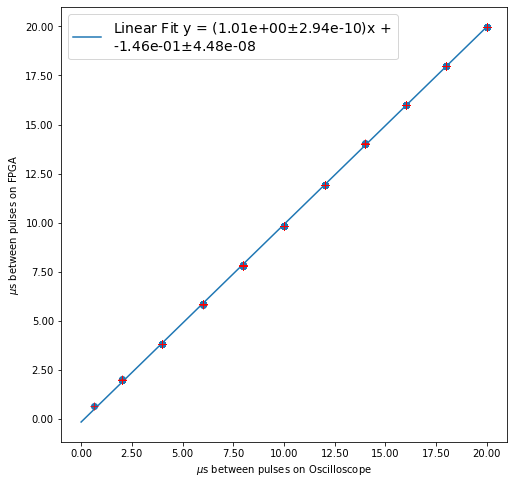

In [75]:
fig2, ax2 = plt.subplots()
x2 = threshdata['OSC']
y2 = threshdata['FPGA']
ax2.scatter(x2, y2)
yerror1 = xerror1 = 0.001
yerror1 = np.full(len(threshdata['FPGA']), yerror1)
# m2,b2 = np.polyfit(x2, y2, 1) #polynomial fitting algorithm
eq, covariance = scipy.optimize.curve_fit(lambda x,m,b: m*x+b, x2, y2, sigma=yerror1, p0=None, absolute_sigma=True)
covDiag3 = np.diag(covariance)
model_func = eq[0]*x2+eq[1]
chi_sqrd = np.sum((y2-model_func)**2/yerror1**2)
degrees_of_freedom = len(x2)-len(eq) # double check this!!
rd_chi = chi_sqrd/float(degrees_of_freedom)
print(f"chi_sqrd {chi_sqrd}  rd_chi {rd_chi}")

linspx1 = np.linspace(0,20,num=100) #random x points
ax2.plot(linspx1, eq[0]*linspx1+eq[1], label='Linear Fit y = ({:.2e}$\pm${:.2e})x + \n{:.2e}$\pm${:.2e}'.format(eq[0],covDiag3[0], eq[1], covDiag3[1])) # plot linear fit
ax2.errorbar(x2,y2,xerr=xerror1,yerr=yerror1, capsize=4, ecolor='red', elinewidth=0.5, markeredgewidth=0.5, linestyle='None')
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xlabel('$\mu$s between pulses on Oscilloscope')
plt.ylabel('$\mu$s between pulses on FPGA')
plt.legend(loc='best', fontsize=14)
plt.show()

### FERMI CONSTANT CALCULATION
##### (requires above to be run for tau)

Tau is 2.043873414985174e-06 ± 1.5526557346075088e-09
We found that the Fermi Constant is 1.2066226875356463e-05 ± 2.291567596082431e-09
Fermi Constant True value: 1.1663787e-05 %Error: 0.033352586480732346
tau caluclated 2.2020622933917596e-185


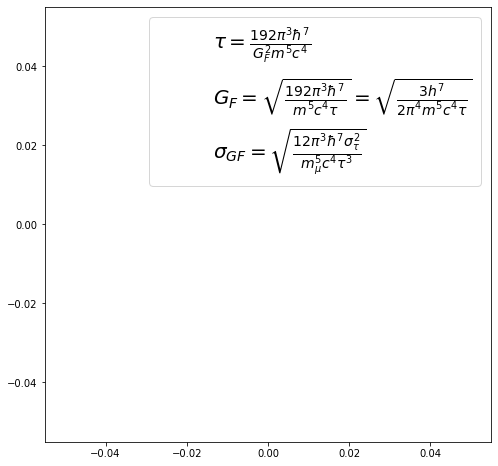

In [74]:
# FERMI CONSTANT CALCULATION 
hbar = 6.582119569e-25 #6.582119569...×10^−16 eV⋅s to GeV⋅s is ×10^−25
c = 299792458 #ms^-1
mu_mass = 1.883531627e-28 #kg  #1.883531627 x 10^-28 kg
mu_mass_energy = 0.1056583755 #GeV 
tau = mean_tau/1e6 #2.0386676671252744 s^-1
std_tau = (mean_tau_sigma)/1e6
G_f_true_value = 1.1663787e-5 #1.1663787 x 10^-5 GeV^-2
tau_calculated = 192*np.pi**3*hbar**7 / ((G_f_true_value)**2 *mu_mass_energy**5 *c**4)
G_f = np.sqrt((192 * np.pi**3 * hbar)/(mu_mass_energy**5 *tau)) #
sigma_G_f = np.sqrt((12*np.pi**3 *hbar *std_tau**2)/(mu_mass_energy**5 * tau**3))
print(f"Tau is {tau} ± {std_tau}")
print(f"We found that the Fermi Constant is {G_f} ± {sigma_G_f}")
print(f"Fermi Constant True value: {G_f_true_value} %Error: {abs(G_f_true_value-G_f)/G_f}")
print(f"tau caluclated {tau_calculated}")
plt.plot([],[],label=r'$\tau = \frac{192\pi^3\hbar^7}{G_F^2 m^5 c^4}$',ls='None')
plt.plot([],[],label=r'$G_F = \sqrt{\frac{192\pi^3\hbar^7}{m^5 c^4 \tau}} = \sqrt{\frac{3 h^7}{2\pi^4 m^5 c^4 \tau}}$',ls='None')
plt.plot([],[],label=r'$\sigma_{GF} = \sqrt{\frac{ 12 \pi^3 \hbar^7 \sigma_\tau^2}{m_\mu^5 c^4 \tau^3}}$',ls='None')
plt.legend(loc='best', fontsize=20)
plt.show()

### SPECIAL RELATIVITY CALCULATIONS

In [67]:
c = 299792458. #ms^-1

def gamma(velocity):
    return 1/np.sqrt(1 - ((velocity**2) / (c**2)))
def tprime(t, velocity):
    return t * gamma(velocity)
def tprime1(t, velocity):
    return t / gamma(velocity)
def lengthcontraction(l, velocity):
    return l / gamma(velocity)
def wow(tprime, t):
    return np.sqrt((1 - (t / tprime)**2)*c**2)
def relKE(m, v, rest):
    return gamma(v)*m*c**2 - rest
def findv(KE, m):
    return np.sqrt(2*KE/m)


mu_mass = 1.883531627e-28 #kg  #1.883531627 x 10^-28 kg
mu_mass_energy = 0.1056583755 #GeV 
taulit = 2.1969811e-6    
v = 0.9997*c#np.sqrt((2*mu_mass_energy*c**2*(2*mu_mass_energy*c**2-1))/(mu_mass_energy+4*mu_mass_energy**2*c**2))
#KE = m₀c² * [√(1 - v²/c²) -1]
t = tprime(taulit, v)
print("test {:.20f} c".format(v/c))
print("CLASSICAL")
print("ratio {:.2e}".format(np.exp(-(15000/v)/taulit)))
print("tau {:.3f} microseconds".format(taulit*1e6))
print("\n")
print("RELATIVISTIC")
print("Earth Observer: tau {:.3f} microseconds".format(15000/v *1e6))
print("Muon  Observer: distance traveled {:.3f} km".format(lengthcontraction(15, v)))
print("Muon  Observer: time with length contraction: {:.3f} microseconds".format(lengthcontraction(15, v)*1000/v*1e6))
print("Muon  Observer: ratio {:f}".format(np.exp(-(lengthcontraction(15, v)*1000/v)/taulit)))
print("Muon  Observer: or its time traveled {:f} microseconds".format(tprime(taulit, v)*1e6))
print("ratio {:f}".format(np.exp(-(15000/v)/tprime(taulit, v))))

test 0.99970000000000003304 c
CLASSICAL
ratio 1.28e-10
tau 2.197 microseconds


RELATIVISTIC
Earth Observer: tau 50.050 microseconds
Muon  Observer: distance traveled 0.367 km
Muon  Observer: time with length contraction: 1.226 microseconds
Muon  Observer: ratio 0.572365
Muon  Observer: or its time traveled 89.698105 microseconds
ratio 0.572365


In [ ]:
# ===========
# EXTRA 
# ===========
# Calculate two tailed p-value by making cumulative distribution function (copied from example)
# Now, calculate weighted average of g measured.
# weights = np.sum(1 / np.sqrt(covDiag)[1])# w_i
# count_wtavg = (1/weights)*np.sum(eq1[1] / np.sqrt(covDiag[1])) #wieghted x bar
# count_wtavg_STD = np.sqrt(1/np.sum(1/covDiag)) #sigma_{x bar}
# print('count weighted average = ',count_wtavg, '+/-', count_wtavg_STD)
# # Comapre measured and predicted value using Gaussian z-score.
# Zscore = (eq1[1] - count_wtavg)/count_wtavg_STD
# print('Z score = ', Zscore)
# cdf = stats.norm.cdf(Zscore,0,1)
# print ("CDF = ",cdf)
# if cdf>0.5:
#     pvalue_2t = 2*(1-cdf)
# else :
#     pvalue_2t=2*(cdf)
# print ("two tailed p-value = ",pvalue_2t)